In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import openpyxl
from scipy.signal import find_peaks

In [25]:
def spectrum(file1, file2, save_name, label1="sp1", label2="sp2"):

    path1 = os.path.join("DataSet", "G6-1", "sp1", file1)
    path2 = os.path.join("DataSet", "G6-1", "sp2", file2)
    path3 = os.path.join("Pictures", save_name)
    
    def read_files(filepath):
        wavelengths = []
        intensities = []
        with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()

        #DataStart以降の行を抽出
        start_index = None
        for i, line in enumerate(lines):
            if "DataStart" in line:
                start_index = i + 1
                break

        #データ部分を読み取る
        for line in lines[start_index:]:
            if not line.strip():
                continue
            try:
                wl, val = map(float, line.split())
                wavelengths.append(wl)
                intensities.append(val)
            except ValueError:
                continue
        return wavelengths, intensities

    #両ファイルを読み込み
    wl1, val1 = read_files(path1)
    wl2, val2 = read_files(path2)

    #グラフ描画
    plt.figure(figsize=(7, 4))
    plt.plot(wl1, val1, label=label1, linewidth=1, color="crimson")
    plt.plot(wl2, val2, label=label2, linewidth=1, color="royalblue")
    plt.xlabel("Wavelength [nm]", fontsize=14)
    plt.ylabel("Intensity [a.u.]", fontsize=14)
    plt.xlim(400, 700)
    #plt.legend(loc="upper right", borderaxespad=2, fontsize=16)
    plt.legend(loc="upper right", fontsize=14)
    plt.tight_layout()
    plt.savefig(path3)
    plt.show()

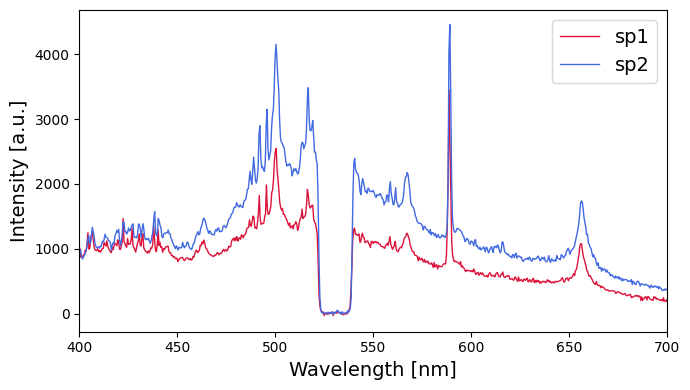

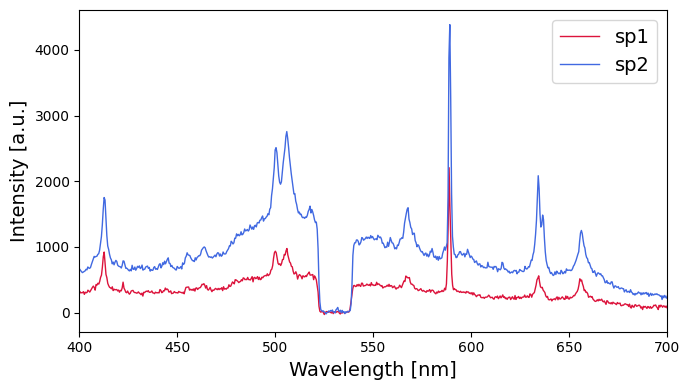

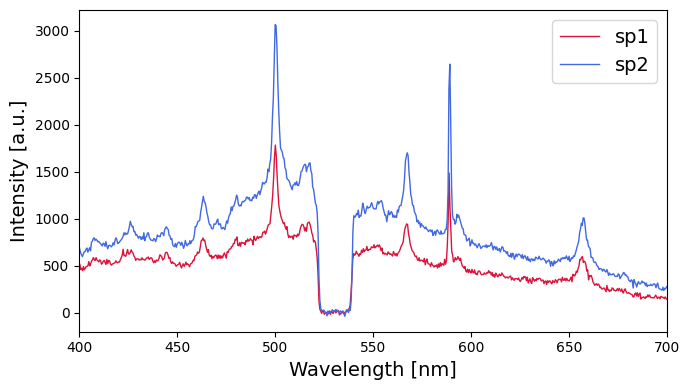

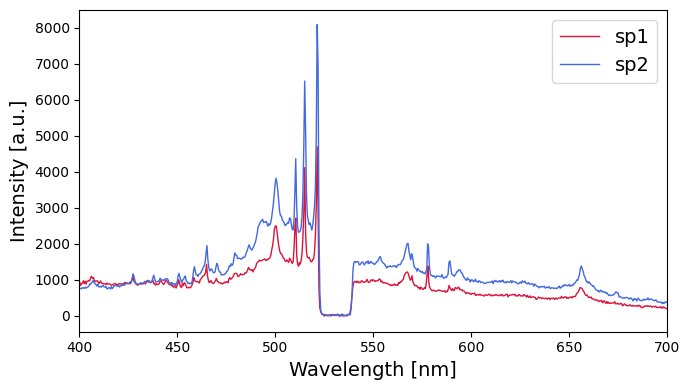

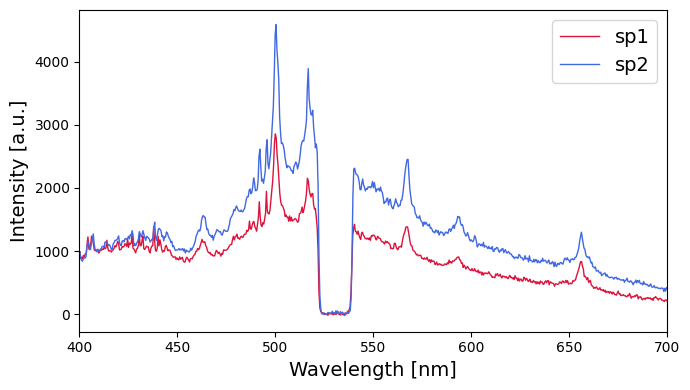

In [26]:
files_sp1 = ["sp1-22.txt", "sp1-23.txt", "sp1-24.txt", "sp1-25.txt", "sp1-26.txt"]
files_sp2 = ["sp2-22.txt", "sp2-23.txt", "sp2-24.txt", "sp2-25.txt", "sp2-26.txt"]

for i in range(0, 5):
    spectrum(files_sp1[i], files_sp2[i], f"A6-2_{i+1}.png")

In [84]:
def specific(sp1_path, sp2_path, excel_path, save_name):
    def read_files(filepath):
        wavelengths, intensities = [], []
        with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()
        
        start_index = 0
        for i, line in enumerate(lines):
            if "DataStart" in line:
                start_index = i + 1
                break
        
        for line in lines[start_index:]:
            if not line.strip(): continue
            try:
                wl, val = map(float, line.split())
                wavelengths.append(wl)
                intensities.append(val)
            except ValueError: continue
        return np.array(wavelengths), np.array(intensities)

    # 1. 計測データの読み込み
    meas_wl_1, meas_int_1 = read_files(sp1_path)
    meas_wl_2, meas_int_2 = read_files(sp2_path)
    
    # 2. Excelファイルの読み込み
    excel = pd.ExcelFile(excel_path)
    sheet_names = excel.sheet_names[:4]  # 最初の4シートを取得

    # 3. 2x2のサブプロットを作成
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    axes = axes.flatten()  

    for i, sheet in enumerate(sheet_names):
        ax = axes[i]

        #エクセルデータ
        df = pd.read_excel(excel, sheet_name=sheet, usecols=[0, 1], names=["wavelength", "Aki"], header=None)
        df["wavelength"] = pd.to_numeric(df["wavelength"], errors='coerce')
        df["Aki"] = pd.to_numeric(df["Aki"], errors='coerce')
        df = df.dropna(subset=["wavelength", "Aki"])

        #実験データ
        ax.plot(meas_wl_1, meas_int_1, color='red', linewidth=0.5, label='sp1', alpha=0.7)
        ax.plot(meas_wl_2, meas_int_2, color='blue', linewidth=0.5, label='sp2', alpha=0.7)
        
        if not df.empty:
            #Aki強度を計測データの最大値に合わせて正規化
            scale_factor = meas_int_2.max() / df["Aki"].max()
            ax.vlines(df["wavelength"], 0, df["Aki"]*scale_factor, 
                       color='orange', linewidth=1.2, label=f'Ref: {sheet}', alpha=0.6)

        
        # 各グラフの装飾
        ax.set_xlim(400, 600)
        ax.set_ylim(0,)
        ax.set_title(f"Material: {sheet}", fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=14)
        ax.grid(True, linestyle=':', alpha=0.6)
        
        # 下段のグラフだけにX軸ラベルを表示
        if i >= 2:
            ax.set_xlabel("Wavelength (nm)", fontsize=14)
        # 左列のグラフだけにY軸ラベルを表示
        if i % 2 == 0:
            ax.set_ylabel("Intensity [a.u.]")

    plt.tight_layout()
    plt.savefig(save_name)
    plt.show()

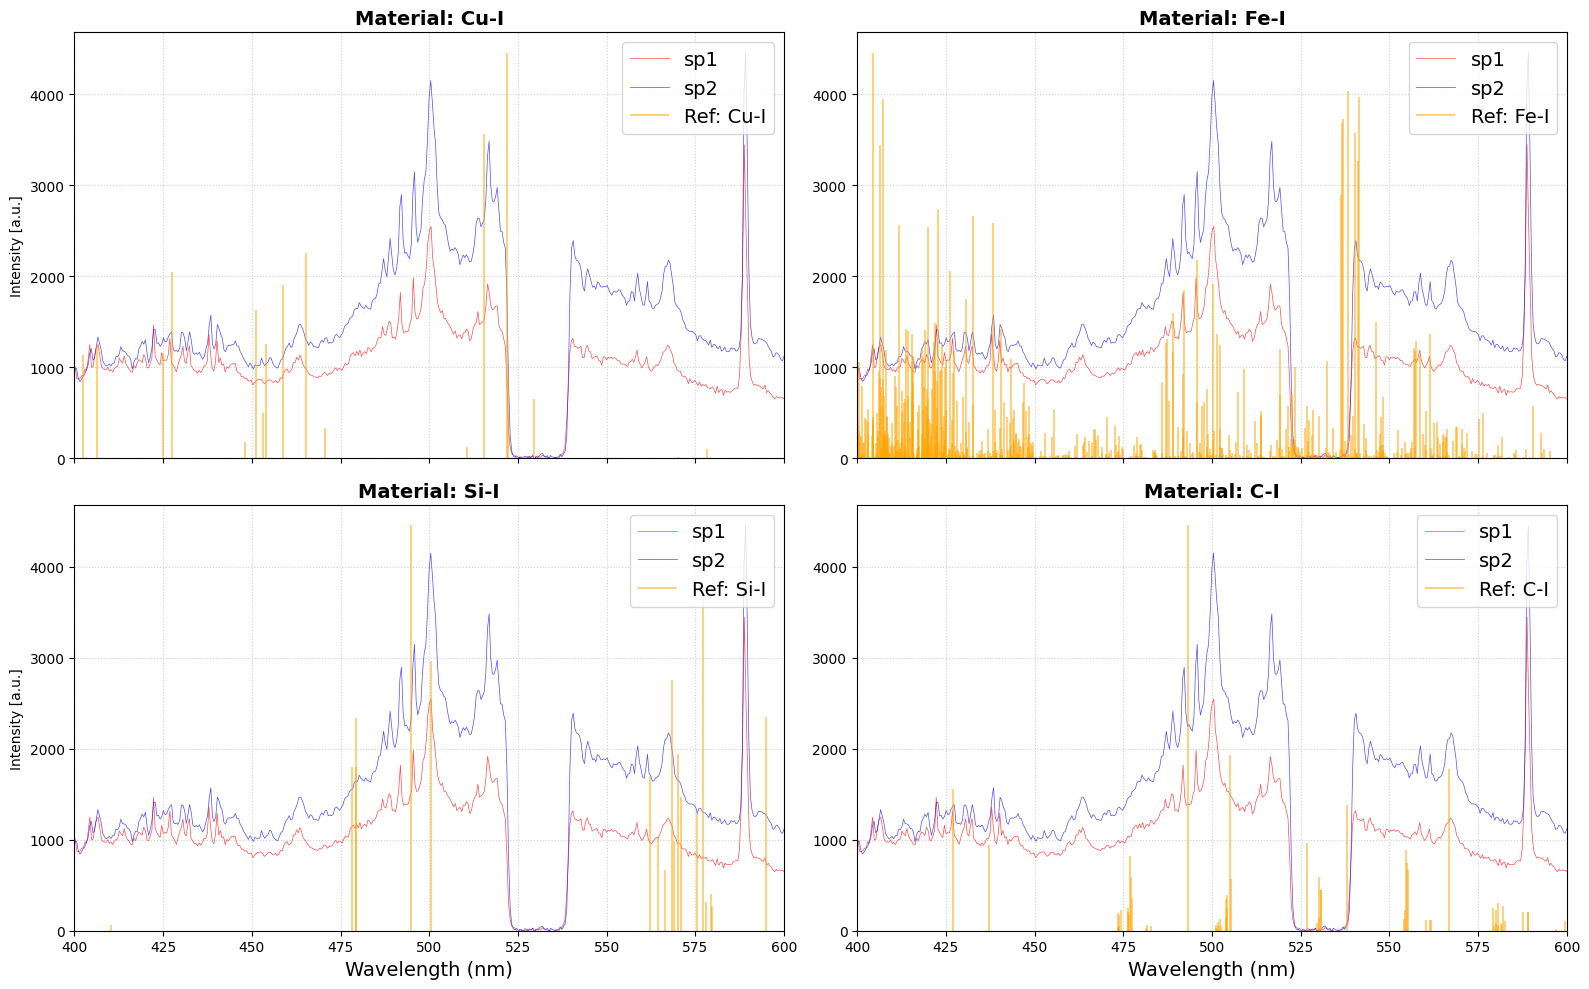

In [85]:
specific(sp1_path="DataSet/G6-1/sp1/sp1-22.txt",
        sp2_path="DataSet/G6-1/sp2/sp2-22.txt",
        excel_path="DataSet/NIST_Spectral_data.xlsx",
        save_name="Pictures/A6-2_6.png")

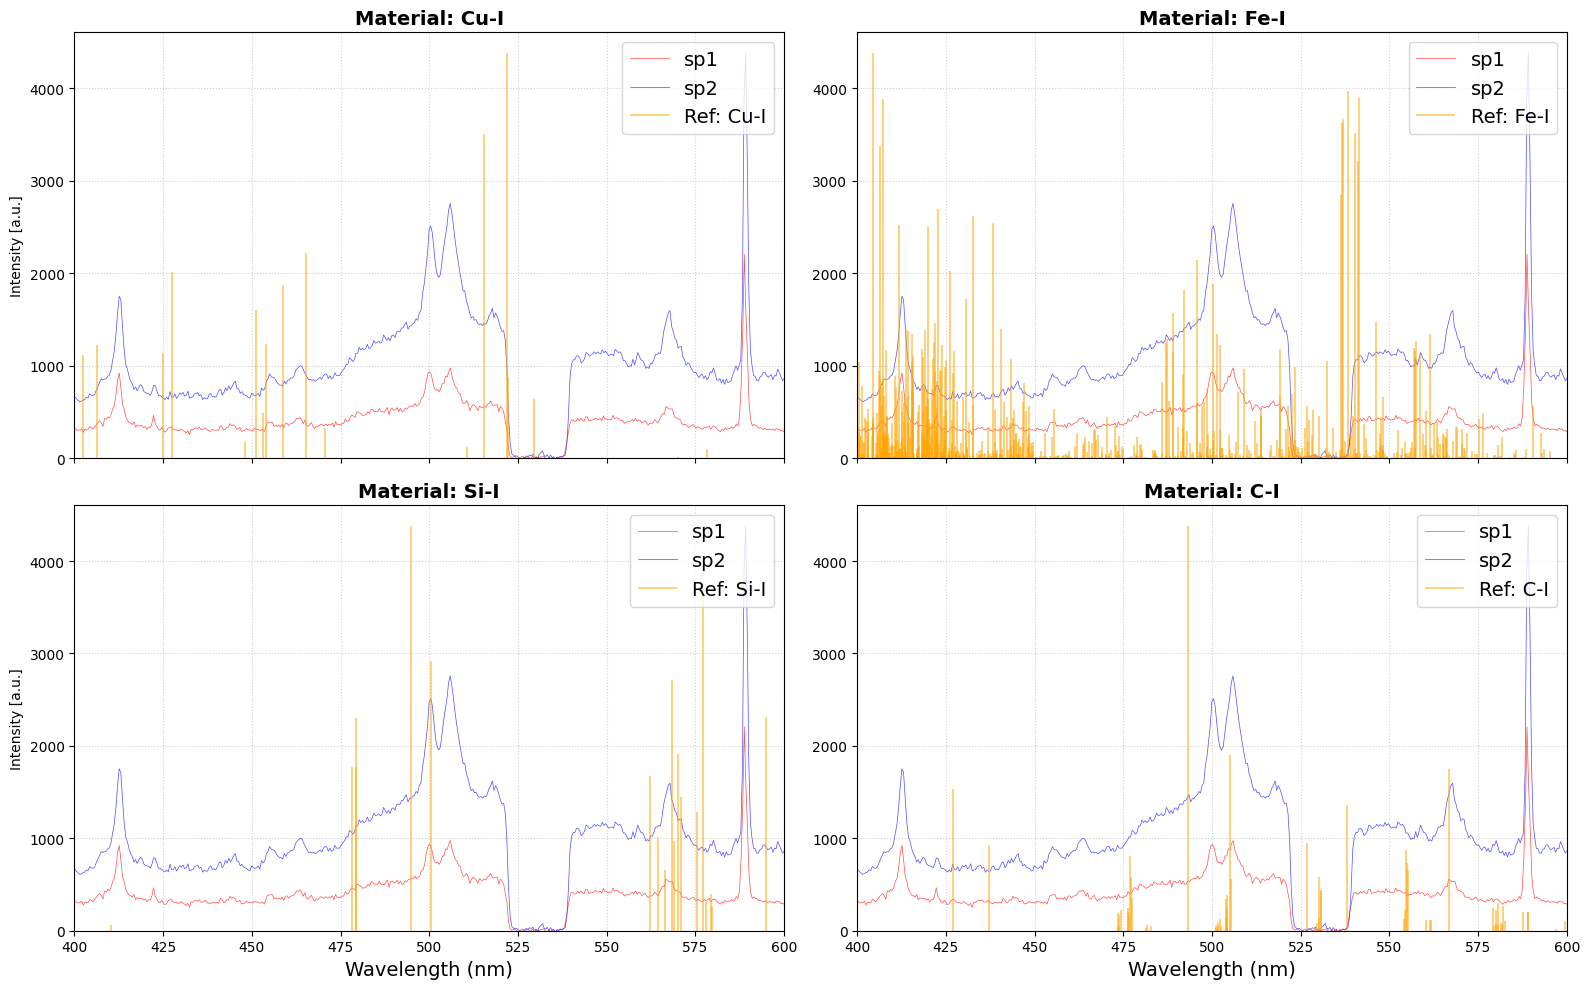

In [86]:
specific(sp1_path="DataSet/G6-1/sp1/sp1-23.txt",
        sp2_path="DataSet/G6-1/sp2/sp2-23.txt",
        excel_path="DataSet/NIST_Spectral_data.xlsx",
        save_name="Pictures/A6-2_7.png")

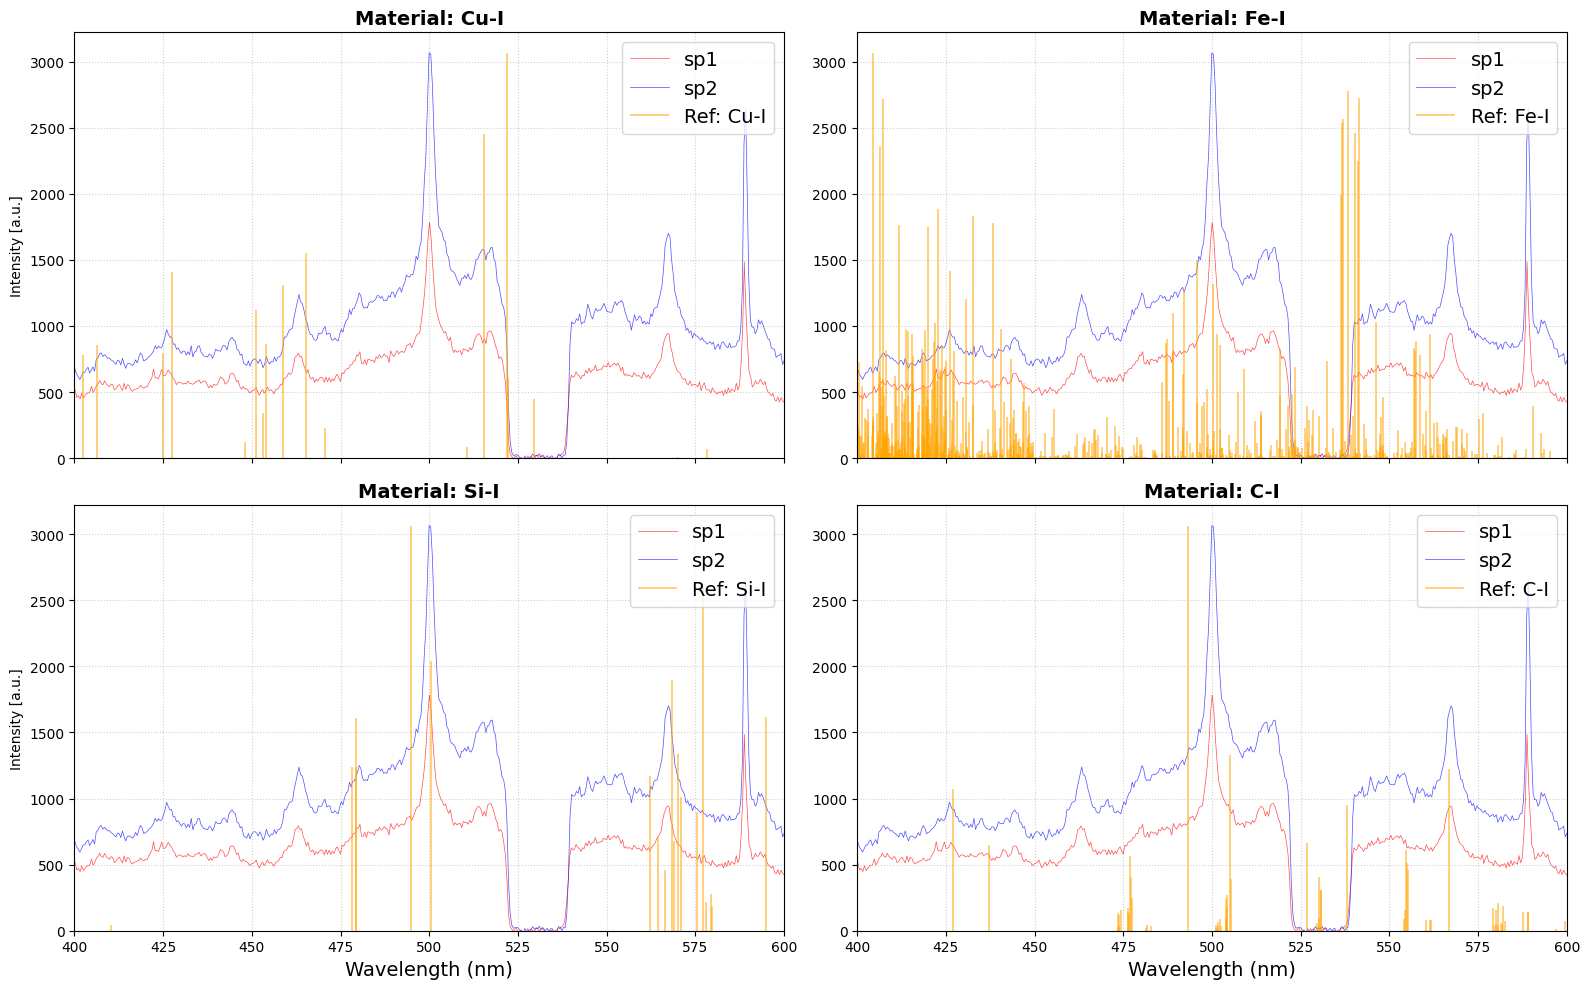

In [87]:
specific(sp1_path="DataSet/G6-1/sp1/sp1-24.txt",
        sp2_path="DataSet/G6-1/sp2/sp2-24.txt",
        excel_path="DataSet/NIST_Spectral_data.xlsx",
        save_name="Pictures/A6-2_8.png")

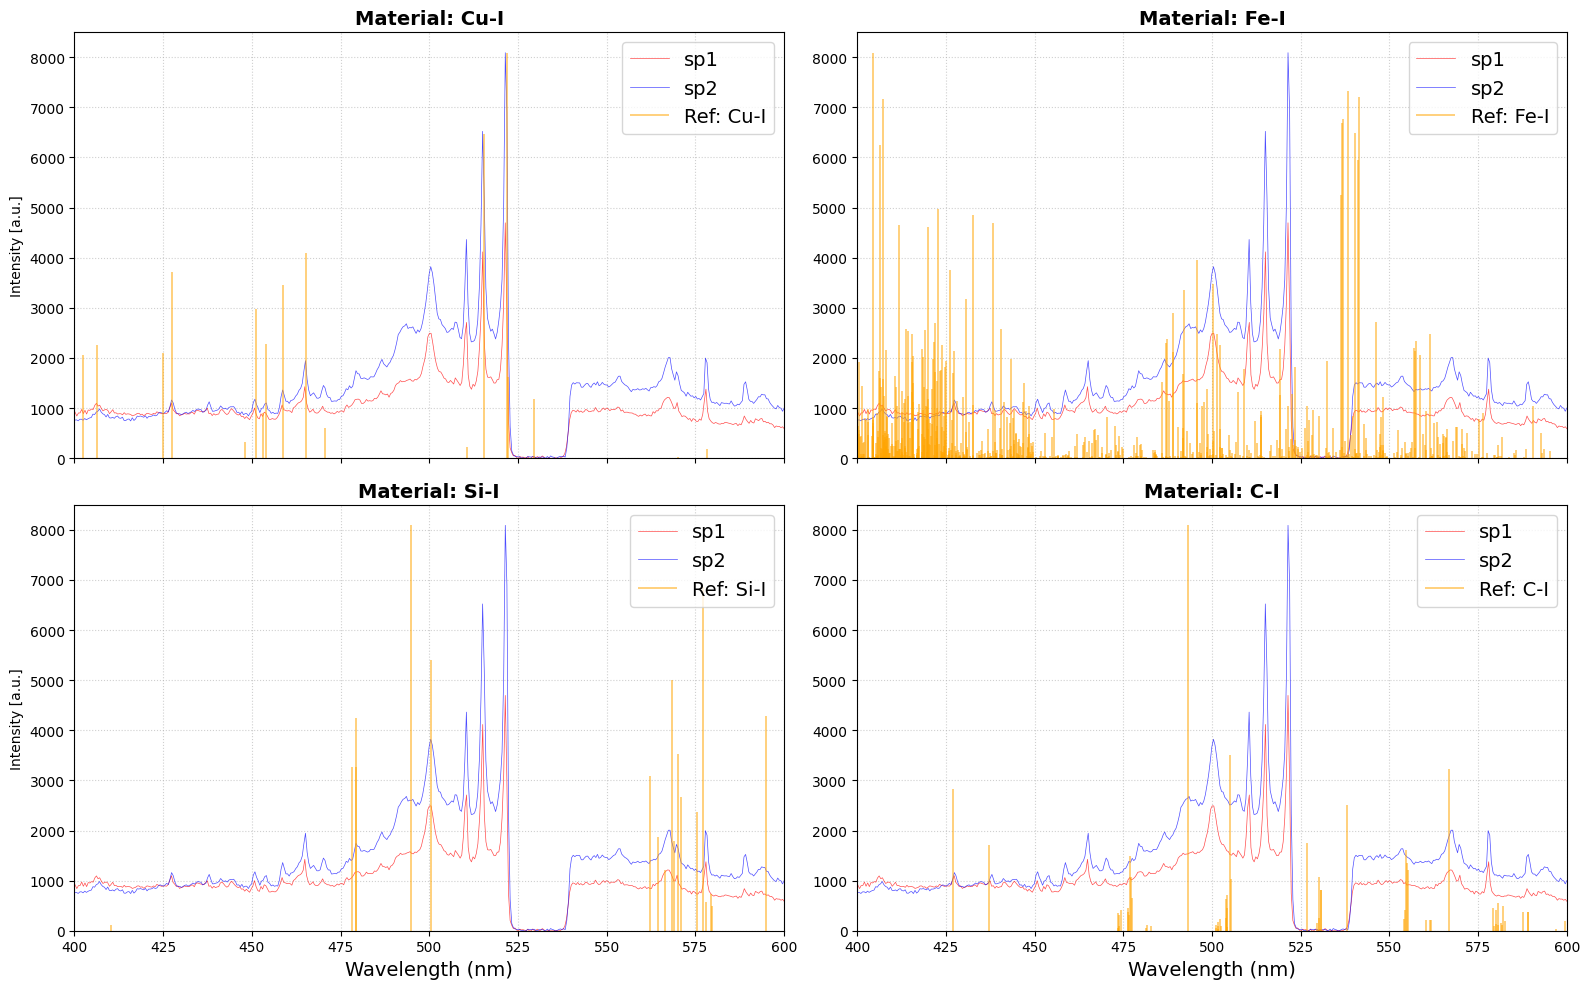

In [88]:
specific(sp1_path="DataSet/G6-1/sp1/sp1-25.txt",
        sp2_path="DataSet/G6-1/sp2/sp2-25.txt",
        excel_path="DataSet/NIST_Spectral_data.xlsx",
        save_name="Pictures/A6-2_9.png")

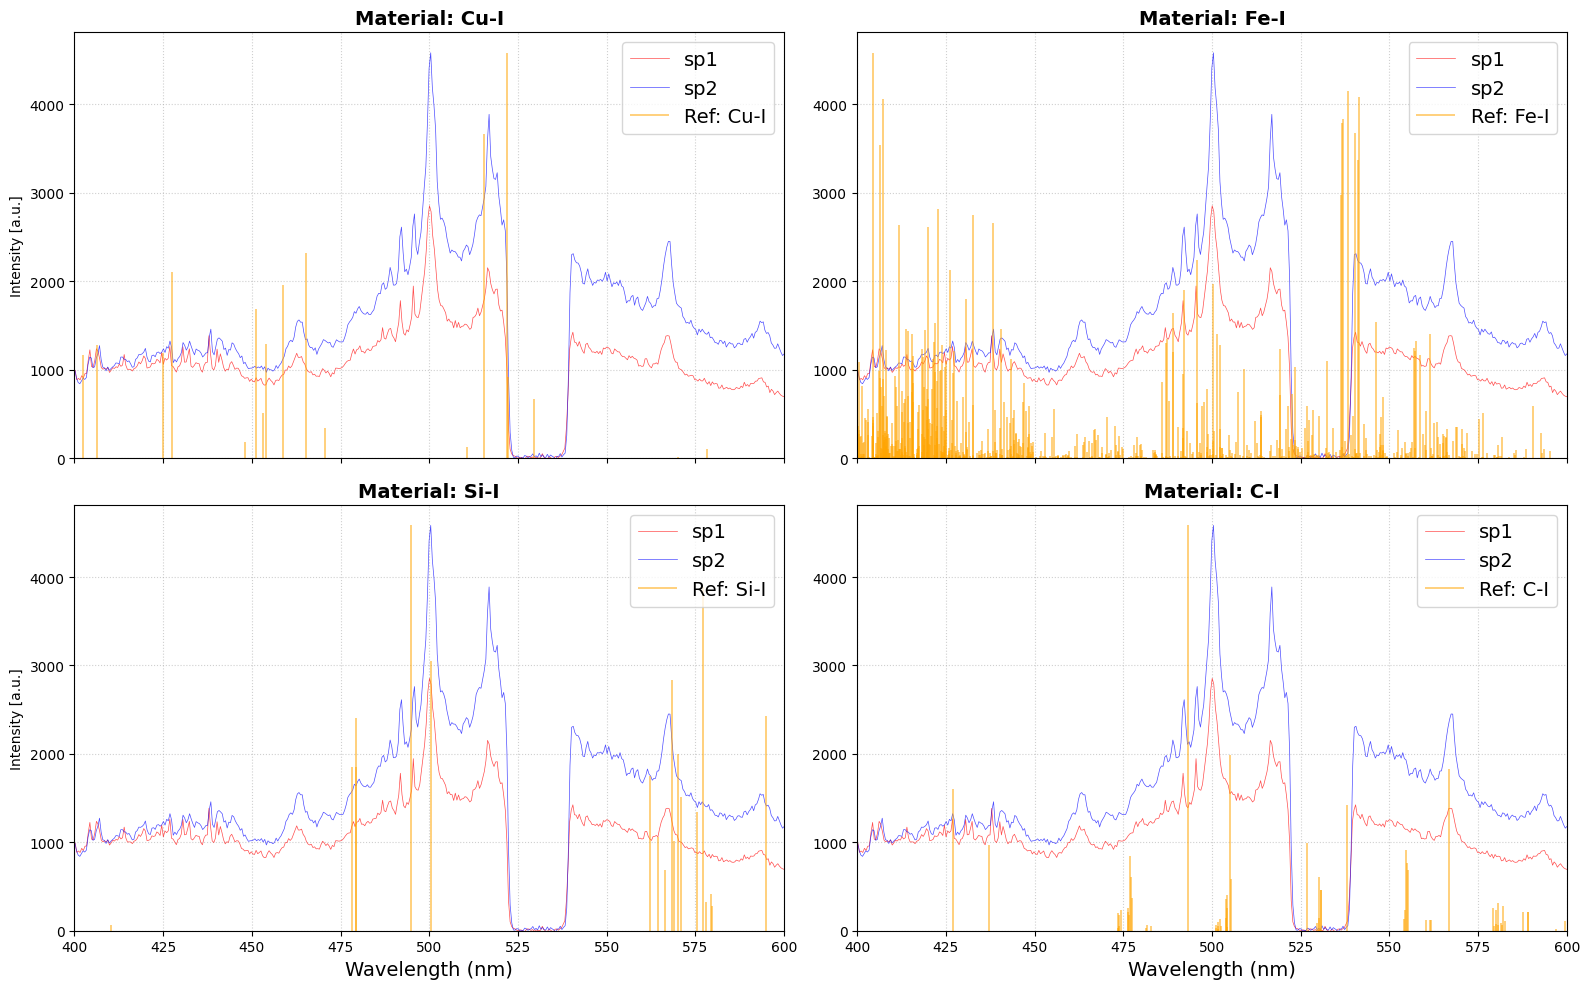

In [89]:
specific(sp1_path="DataSet/G6-1/sp1/sp1-26.txt",
        sp2_path="DataSet/G6-1/sp2/sp2-26.txt",
        excel_path="DataSet/NIST_Spectral_data.xlsx",
        save_name="Pictures/A6-2_10.png")